## PlayerUnknown's Battlegrounds - Analysis of the top 88,000 Best Players
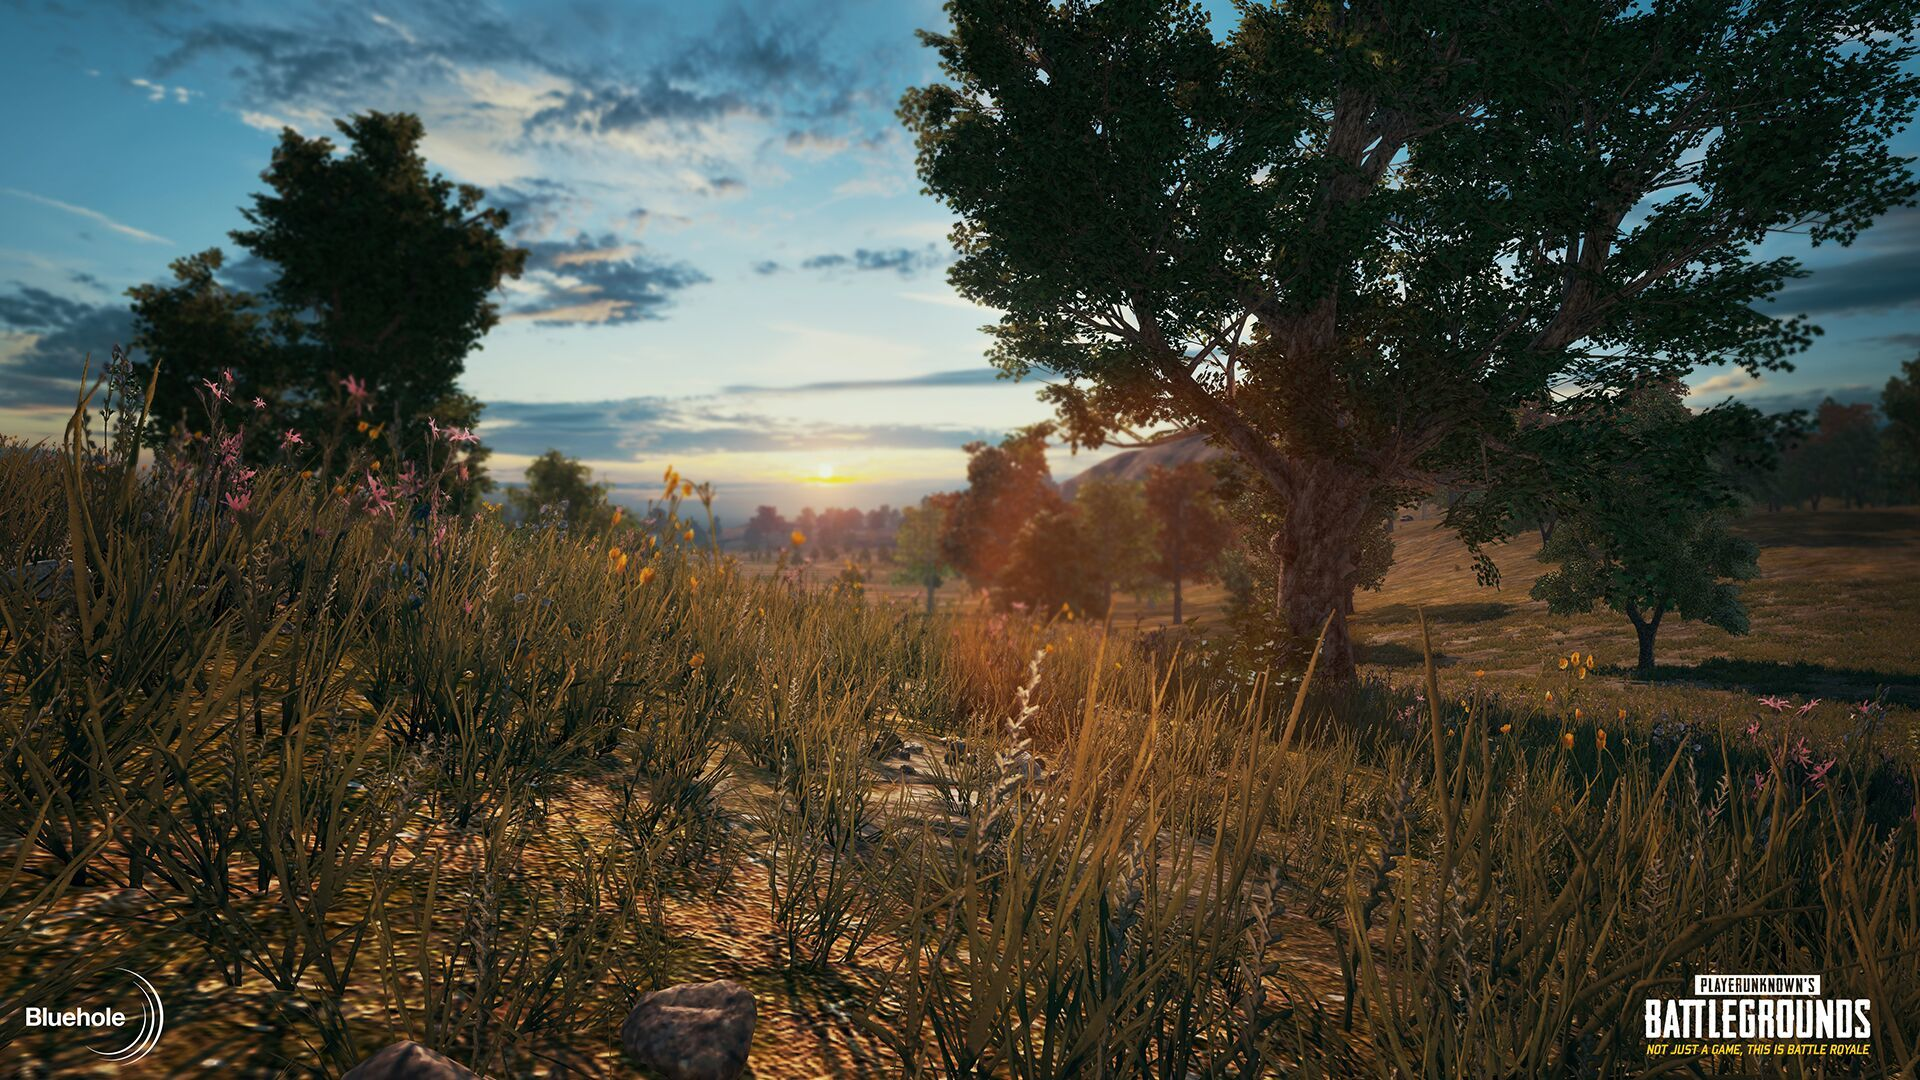

### Some notes to get started
Outlier / anamoly detection

Look at players above WinRatio threshold

Prediction based on features: win percentage per game (pg)?

In [111]:
# Import the good stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [214]:
sns.set(style="whitegrid", color_codes=True)
plt.style.use('seaborn-colorblind')

In [316]:
# Read in data
df = pd.read_csv('PUBG_Player_Statistics.csv')

In [113]:
df.head()
num_players = df.shape[0]
num_features = df.shape[1]
num_solof = len(df.columns[df.columns.str.contains('solo')])
num_duof = len(df.columns[df.columns.str.contains('duo')])
num_squadf = len(df.columns[df.columns.str.contains('squad')])

In [6]:
num_features

152

In [7]:
num_players

87898

In [15]:
len(df.columns[df.columns.str.contains('solo')])

50

In [22]:
num_duof

50

In [23]:
num_squadf

50

In [27]:
df.head(10)

player_name  tracker_id  solo_KillDeathRatio  solo_WinRatio  \
0      BreakNeck        4405                 3.14          17.65   
1      Blackwalk        8199                 4.41          18.18   
2  mercedes_benz        4454                 3.60           0.00   
3           DORA        7729                14.00          50.00   
4        n2tstar           0                10.50          33.33   
5     coldoxygen       33313                 5.73          31.25   
6          Giken       15585                 2.45           8.45   
7       KoreaNo1        9454                 2.71          26.32   
8          undor       24029                 3.68          13.64   
9        Fordune       11289                 4.17          25.00   

   solo_TimeSurvived  solo_RoundsPlayed  solo_Wins  solo_WinTop10Ratio  \
0           18469.14                 17          3                0.83   
1           33014.86                 33          6                0.36   
2            4330.44                  5          0                0.00   
3           13421.82                  8          4                0.67   
4            9841.04                  6          2                0.40   
5           22003.22                 16          5                0.50   
6          148051.25                142         12                0.18   
7           26091.14                 19          5                0.50   
8           49282.41                 44          6                0.23   
9           10280.77                  8          2                0.25   

   solo_Top10s  solo_Top10Ratio     ...       squad_RideDistance  \
0            4             23.5     ...               3751590.99   
1           11             33.3     ...               4295917.30   
2            1             20.0     ...               3935265.63   
3            6             75.0     ...               2738998.00   
4            5             83.3     ...               2347295.00   
5           10             62.5     ...               3218436.00   
6           34             23.9     ...               2057423.12   
7           10             52.6     ...               3586593.00   
8           13             29.5     ...               1054263.00   
9            4             50.0     ...               2793909.91   

   squad_MoveDistance  squad_AvgWalkDistance  squad_AvgRideDistance  \
0          5194786.58                2626.97                4372.64   
1          6051783.67                2422.48                6009.73   
2          5589608.74                1871.89                3011.87   
3          3796916.00                2154.62                5578.41   
4          3220260.00                2098.47                5642.54   
5          4733977.00                2078.93                4414.86   
6          2883099.31                1664.77                3022.51   
7          4854387.00                1635.86                4627.86   
8          1550975.00                2207.61                4685.61   
9          4071039.87                1981.29                3635.28   

   squad_LongestKill  squad_Heals  squad_Revives  squad_Boosts  \
0             536.98         2186            234          1884   
1             734.85         2041            276          2340   
2             725.44         1766            210          2193   
3             587.28         1214            142          1252   
4             546.10         1245            120           923   
5            1212.76         2023            195          2307   
6             564.20         1274            133          1320   
7             806.24         2199            163          1864   
8             455.67          617             61           585   
9             546.95         1320            220          1338   

   squad_DamageDealt  squad_DBNOs  
0          242132.73         1448  
1          269795.75         1724  
2          292977.07         1897  
3          181106.90         1057  
4  

In [24]:
def getModeFeatures(df, mode):
    return df.columns[df.columns.str.contains(mode)] 

In [25]:
getModeFeatures(df, 'solo')

Index(['solo_KillDeathRatio', 'solo_WinRatio', 'solo_TimeSurvived',
       'solo_RoundsPlayed', 'solo_Wins', 'solo_WinTop10Ratio', 'solo_Top10s',
       'solo_Top10Ratio', 'solo_Losses', 'solo_Rating', 'solo_BestRating',
       'solo_DamagePg', 'solo_HeadshotKillsPg', 'solo_HealsPg', 'solo_KillsPg',
       'solo_MoveDistancePg', 'solo_RevivesPg', 'solo_RoadKillsPg',
       'solo_TeamKillsPg', 'solo_TimeSurvivedPg', 'solo_Top10sPg',
       'solo_Kills', 'solo_Assists', 'solo_Suicides', 'solo_TeamKills',
       'solo_HeadshotKills', 'solo_HeadshotKillRatio', 'solo_VehicleDestroys',
       'solo_RoadKills', 'solo_DailyKills', 'solo_WeeklyKills',
       'solo_RoundMostKills', 'solo_MaxKillStreaks', 'solo_WeaponAcquired',
       'solo_Days', 'solo_LongestTimeSurvived', 'solo_MostSurvivalTime',
       'solo_AvgSurvivalTime', 'solo_WinPoints', 'solo_WalkDistance',
       'solo_RideDistance', 'solo_MoveDistance', 'solo_AvgWalkDistance',
       'solo_AvgRideDistance', 'solo_LongestKill', 'solo_

In [ ]:
plt.figure(1)
sns.

In [26]:
3  / 17

0.17647058823529413

In [29]:
(df.solo_WinRatio > 50).sum()

593

<IPython.core.display.Javascript object>


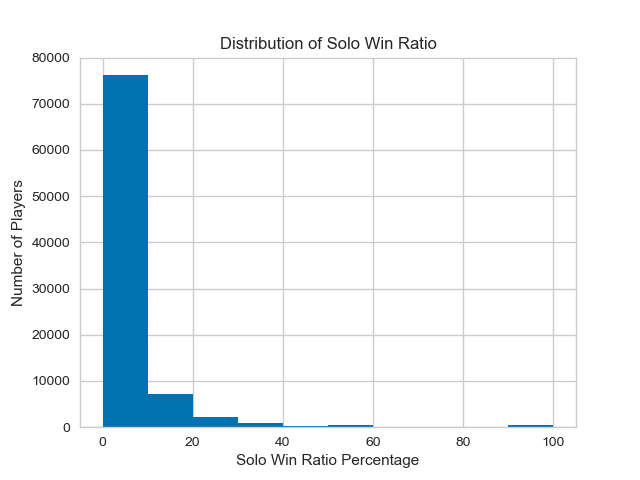

In [215]:
%matplotlib notebook
plt.figure(1)
df.solo_WinRatio.plot.hist();
plt.title("Distribution of Solo Win Ratio")
plt.xlabel('Solo Win Ratio Percentage')
plt.ylabel('Number of Players')
plt.show()

<IPython.core.display.Javascript object>


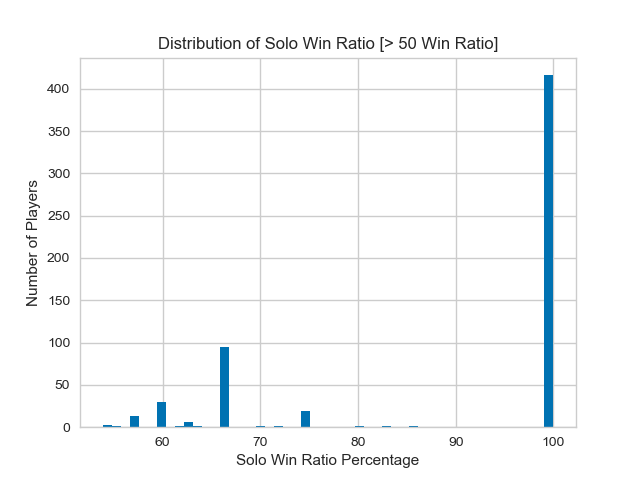

In [216]:
plt.figure(2)
df.solo_WinRatio[(df.solo_WinRatio > 50)].plot.hist(bins = 50);
plt.title("Distribution of Solo Win Ratio [> 50 Win Ratio]")
plt.xlabel('Solo Win Ratio Percentage')
plt.ylabel('Number of Players')
plt.show()

In [71]:
df[(df.solo_WinRatio == 100)].solo_RoundsPlayed.value_counts()

1    371
2     36
3      7
6      1
4      1
Name: solo_RoundsPlayed, dtype: int64

In [104]:
df[(df.solo_WinRatio == 100) & (df.solo_RoundsPlayed == 1)].loc[:,getModeFeatures(df, 'solo')].head(3)

solo_KillDeathRatio  solo_WinRatio  solo_TimeSurvived  solo_RoundsPlayed  \
297                  4.0          100.0            1963.65                  1   
498                  5.0          100.0            1905.00                  1   
682                 10.0          100.0            1905.75                  1   

     solo_Wins  solo_WinTop10Ratio  solo_Top10s  solo_Top10Ratio  solo_Losses  \
297          1                 1.0            1            100.0            0   
498          1                 1.0            1            100.0            0   
682          1                 1.0            1            100.0            0   

     solo_Rating     ...      solo_RideDistance  solo_MoveDistance  \
297      1331.23     ...                   0.00            3126.37   
498      1342.36     ...                4788.12            7864.76   
682      1341.20     ...                   0.00            3165.45   

     solo_AvgWalkDistance  solo_AvgRideDistance  solo_LongestKill  solo_Heals  \
297               3126.37                  0.00            170.60           3   
498               3076.64               4788.12             24.82           1   
682               3165.45                  0.00            224.15           6   

     solo_Revives  solo_Boosts  solo_DamageDealt  solo_DBNOs  
297             0            6            434.14           0  
498             0            5            564.90           0  
682             0            9            841.32           0  

[3 rows x 50 columns]

<IPython.core.display.Javascript object>


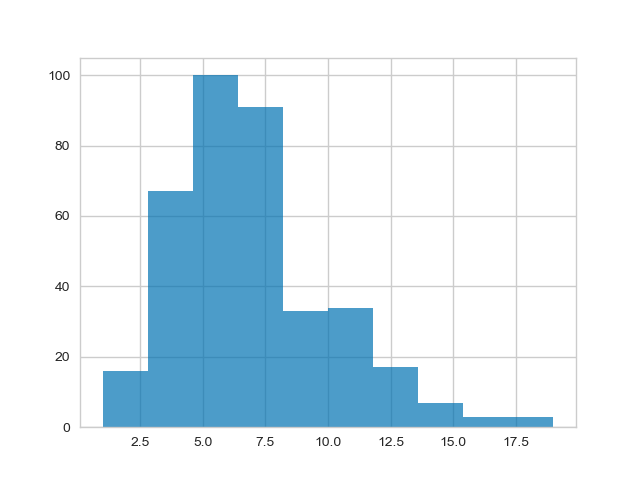

In [217]:
plt.figure(3)
plt.hist(df[(df.solo_WinRatio == 100) & (df.solo_RoundsPlayed == 1)].solo_KillsPg, 10, alpha = 0.7)
plt.show()

In [138]:
x = df[(df.solo_WinRatio == 100) & (df.solo_RoundsPlayed == 1)].solo_DamagePg
y = df[(df.solo_WinRatio == 100) & (df.solo_RoundsPlayed == 1)].solo_MoveDistance

<IPython.core.display.Javascript object>


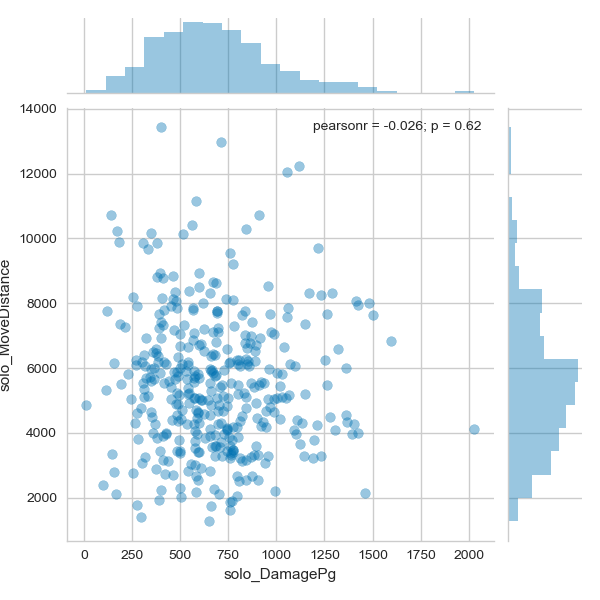

In [218]:
sns.jointplot(x, y, alpha=0.4);

In [155]:
m = df[(df.solo_WinRatio == 100) & (df.solo_RoundsPlayed == 1)].loc[:,['solo_KillsPg','solo_MoveDistancePg', 'solo_LongestKill','solo_RideDistance']]

<IPython.core.display.Javascript object>


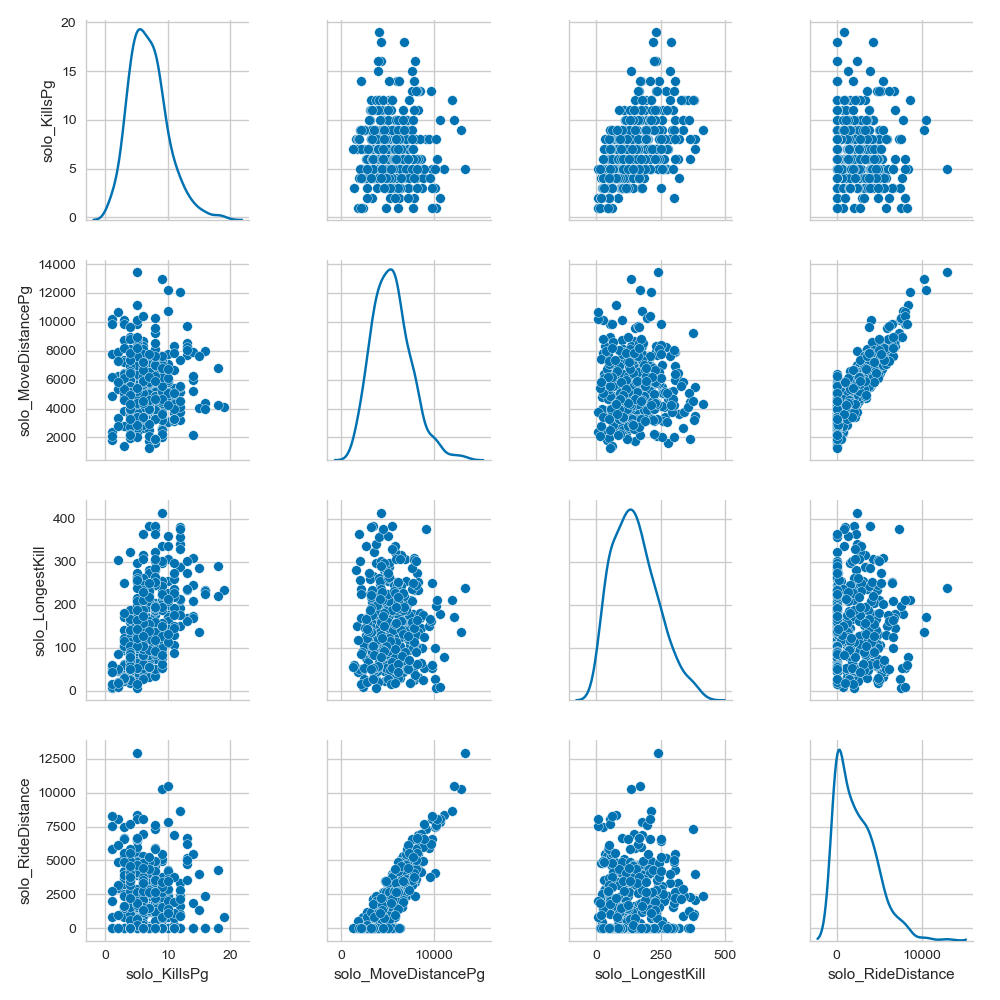

In [219]:
sns.pairplot(m, diag_kind = 'kde')
plt.tight_layout()

In [118]:
getModeFeatures(df, 'solo')

Index(['solo_KillDeathRatio', 'solo_WinRatio', 'solo_TimeSurvived',
       'solo_RoundsPlayed', 'solo_Wins', 'solo_WinTop10Ratio', 'solo_Top10s',
       'solo_Top10Ratio', 'solo_Losses', 'solo_Rating', 'solo_BestRating',
       'solo_DamagePg', 'solo_HeadshotKillsPg', 'solo_HealsPg', 'solo_KillsPg',
       'solo_MoveDistancePg', 'solo_RevivesPg', 'solo_RoadKillsPg',
       'solo_TeamKillsPg', 'solo_TimeSurvivedPg', 'solo_Top10sPg',
       'solo_Kills', 'solo_Assists', 'solo_Suicides', 'solo_TeamKills',
       'solo_HeadshotKills', 'solo_HeadshotKillRatio', 'solo_VehicleDestroys',
       'solo_RoadKills', 'solo_DailyKills', 'solo_WeeklyKills',
       'solo_RoundMostKills', 'solo_MaxKillStreaks', 'solo_WeaponAcquired',
       'solo_Days', 'solo_LongestTimeSurvived', 'solo_MostSurvivalTime',
       'solo_AvgSurvivalTime', 'solo_WinPoints', 'solo_WalkDistance',
       'solo_RideDistance', 'solo_MoveDistance', 'solo_AvgWalkDistance',
       'solo_AvgRideDistance', 'solo_LongestKill', 'solo_

In [194]:
corr = df[(df.solo_WinRatio == 100) & (df.solo_RoundsPlayed == 1)].loc[:,getModeFeatures(df, 'solo')].corr()
t = pd.DataFrame(corr.solo_KillsPg)

<IPython.core.display.Javascript object>


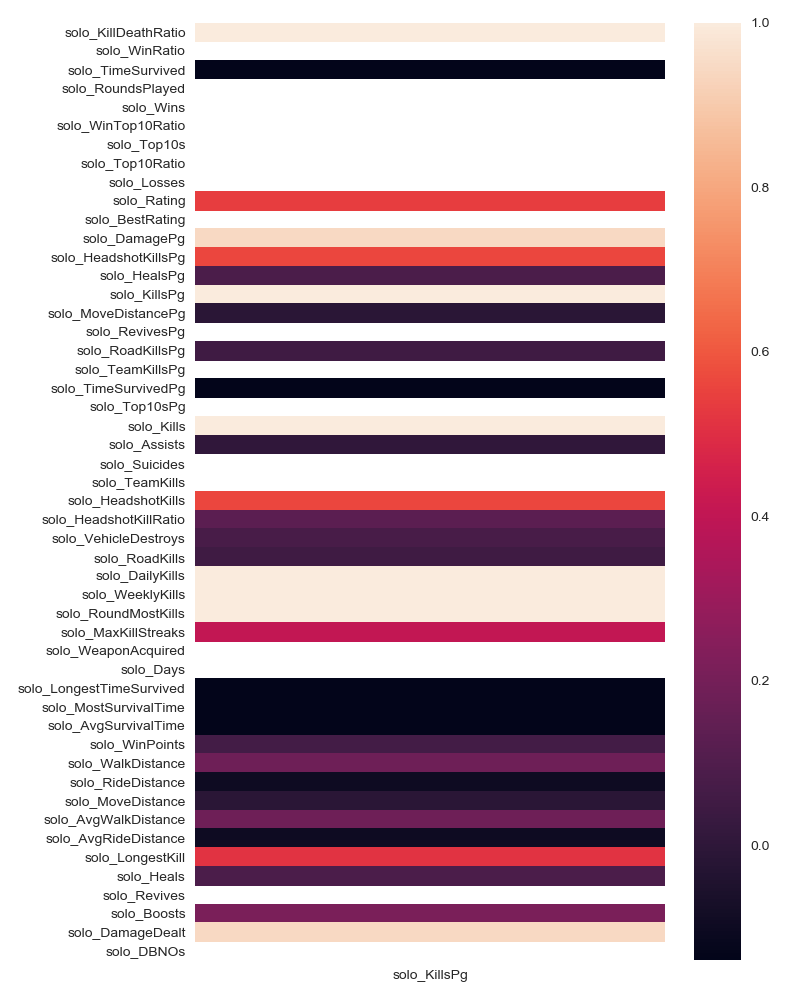

In [222]:
plt.figure(num=6, figsize=(8, 10))
sns.heatmap(t)
plt.yticks(rotation=0)
plt.tight_layout()

## Are Drivers Natural Killers?

<IPython.core.display.Javascript object>


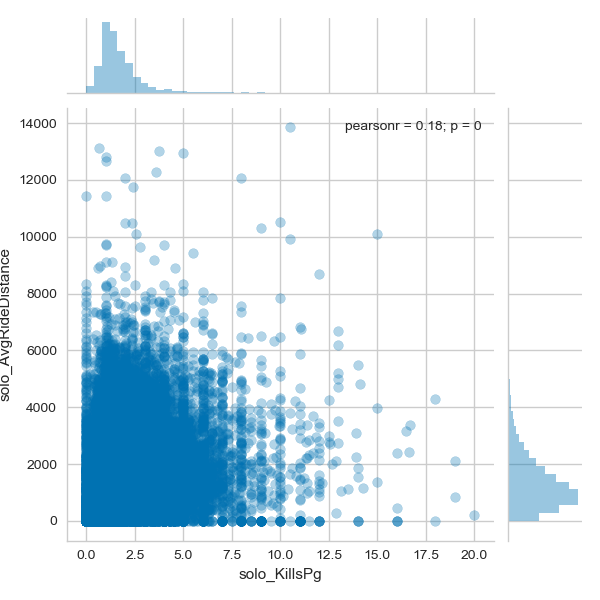

In [350]:
sns.jointplot(df.solo_KillsPg, df.solo_AvgRideDistance, alpha=0.3);

Win ratio vs miles driven

In [359]:
threshold = 600 # frequency of categories
count = df['solo_WinRatio'].value_counts()
categories_to_keep = count[count > threshold].index.tolist()
category_feature = pd.Categorical(df['solo_WinRatio'], 
                categories = categories_to_keep, ordered=True)

In [362]:
s1 = df.solo_AvgRideDistance
s2 = pd.Series(category_feature, name='solo_WinRatioCat')
df_WR_drive = pd.concat([s1, s2], axis=1).dropna()

<IPython.core.display.Javascript object>


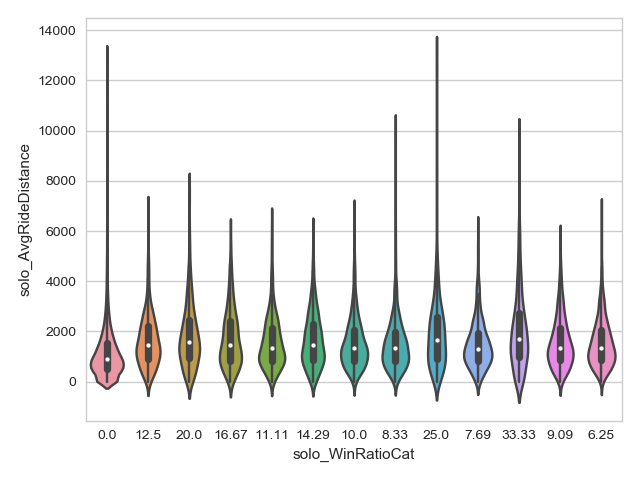

In [363]:
plt.figure()
sns.violinplot(x='solo_WinRatioCat', y='solo_AvgRideDistance', data = df_WR_drive, split=True)
plt.tight_layout()
plt.show()